# MTA Data Challenges

In [1]:
from __future__ import division
import csv
from datetime import datetime
from collections import Counter
import requests

### Challenge 1

In [3]:
#for each day put an html GET request and save file as csv
dates = ['150829', '150905', '150912', '150919'] 
for d in dates:
    r = requests.get('http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + d + '.txt')
    with open('turnstile_' + d + '.csv', 'w+') as f:
        f.write(r.text)

In [4]:
#read in csv files and concat into single list
rows = []
for d in dates:
    with open('turnstile_' + d + '.csv') as f:
        reader = csv.reader(f)
        file_rows = [[cell.strip() for cell in row] for row in reader]
    assert file_rows.pop(0) == ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME',
                       'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES',
                       'EXITS']
    rows += file_rows

In [5]:
#turn first 4 columns into keys and the rest into values
raw_readings = {}
for row in rows:
    raw_readings.setdefault(tuple(row[:4]), []).append(tuple(row[4:]))

In [6]:
raw_readings.items()[0]

(('A030', 'R083', '01-06-00', '23 ST-5 AVE'),
 [('NR',
   'BMT',
   '08/22/2015',
   '00:00:00',
   'REGULAR',
   '0006053309',
   '0003363344'),
  ('NR',
   'BMT',
   '08/22/2015',
   '04:00:00',
   'REGULAR',
   '0006053344',
   '0003363351'),
  ('NR',
   'BMT',
   '08/22/2015',
   '08:00:00',
   'REGULAR',
   '0006053355',
   '0003363386'),
  ('NR',
   'BMT',
   '08/22/2015',
   '12:00:00',
   'REGULAR',
   '0006053424',
   '0003363483'),
  ('NR',
   'BMT',
   '08/22/2015',
   '16:00:00',
   'REGULAR',
   '0006053590',
   '0003363723'),
  ('NR',
   'BMT',
   '08/22/2015',
   '20:00:00',
   'REGULAR',
   '0006053832',
   '0003363885'),
  ('NR',
   'BMT',
   '08/23/2015',
   '00:00:00',
   'REGULAR',
   '0006053991',
   '0003363991'),
  ('NR',
   'BMT',
   '08/23/2015',
   '04:00:00',
   'REGULAR',
   '0006054044',
   '0003364001'),
  ('NR',
   'BMT',
   '08/23/2015',
   '08:00:00',
   'REGULAR',
   '0006054059',
   '0003364011'),
  ('NR',
   'BMT',
   '08/23/2015',
   '12:00:00',
   

### Challenge 2

In [7]:
#parse dates into datetime and counts into integers
datetime_cumulative = {turnstile: [(datetime.strptime(date + time,
                                                      '%m/%d/%Y%X'),
                                    int(in_cumulative))
                                   for _, _, date, time,
                                       _, in_cumulative, _ in rows]
                       for turnstile, rows in raw_readings.items()}

In [9]:
#calculate entries and time periods
datetime_count_times = {turnstile: [[rows[i][0],
                                     rows[i+1][1] - rows[i][1],
                                     rows[i+1][0] - rows[i][0]]
                                    for i in range(len(rows) - 1)]
                        for turnstile, rows in datetime_cumulative.items()}

In [11]:
all_counts = [count for rows in datetime_count_times.values() for _, count, _ in rows]
all_counts.sort()

In [13]:
all_times = [duration.total_seconds() / 60 / 60
             for rows in datetime_count_times.values()
             for _, _, duration in rows]

In [15]:
datetime_counts = {turnstile: [(time, count)
                               for (time, count, _) in rows
                               if 0 <= count <= 5000]
                   for turnstile, rows in datetime_count_times.items()}
datetime_counts.items()[0]

(('A030', 'R083', '01-06-00', '23 ST-5 AVE'),
 [(datetime.datetime(2015, 8, 22, 0, 0), 35),
  (datetime.datetime(2015, 8, 22, 4, 0), 11),
  (datetime.datetime(2015, 8, 22, 8, 0), 69),
  (datetime.datetime(2015, 8, 22, 12, 0), 166),
  (datetime.datetime(2015, 8, 22, 16, 0), 242),
  (datetime.datetime(2015, 8, 22, 20, 0), 159),
  (datetime.datetime(2015, 8, 23, 0, 0), 53),
  (datetime.datetime(2015, 8, 23, 4, 0), 15),
  (datetime.datetime(2015, 8, 23, 8, 0), 67),
  (datetime.datetime(2015, 8, 23, 12, 0), 157),
  (datetime.datetime(2015, 8, 23, 16, 0), 198),
  (datetime.datetime(2015, 8, 23, 20, 0), 127),
  (datetime.datetime(2015, 8, 24, 0, 0), 13),
  (datetime.datetime(2015, 8, 24, 4, 0), 72),
  (datetime.datetime(2015, 8, 24, 8, 0), 407),
  (datetime.datetime(2015, 8, 24, 12, 0), 378),
  (datetime.datetime(2015, 8, 24, 16, 0), 956),
  (datetime.datetime(2015, 8, 24, 20, 0), 300),
  (datetime.datetime(2015, 8, 25, 0, 0), 36),
  (datetime.datetime(2015, 8, 25, 4, 0), 83),
  (datetime.dat

### Challenge 3

In [16]:
#aggregate entry counts to per day counts
day_counts = {}
for turnstile, rows in datetime_counts.items():
    by_day = {}
    for time, count in rows:
        day = time.date()
        by_day[day] = by_day.get(day, 0) + count
    day_counts[turnstile] = sorted(by_day.items())
    
day_counts.items()[0]

(('A030', 'R083', '01-06-00', '23 ST-5 AVE'),
 [(datetime.date(2015, 8, 22), 682),
  (datetime.date(2015, 8, 23), 617),
  (datetime.date(2015, 8, 24), 2126),
  (datetime.date(2015, 8, 25), 2186),
  (datetime.date(2015, 8, 26), 2287),
  (datetime.date(2015, 8, 27), 2189),
  (datetime.date(2015, 8, 28), 1947),
  (datetime.date(2015, 8, 29), 843),
  (datetime.date(2015, 8, 30), 647),
  (datetime.date(2015, 8, 31), 2048),
  (datetime.date(2015, 9, 1), 2231),
  (datetime.date(2015, 9, 2), 2226),
  (datetime.date(2015, 9, 3), 2081),
  (datetime.date(2015, 9, 4), 1785),
  (datetime.date(2015, 9, 5), 742),
  (datetime.date(2015, 9, 6), 556),
  (datetime.date(2015, 9, 7), 570),
  (datetime.date(2015, 9, 8), 2079),
  (datetime.date(2015, 9, 9), 2522),
  (datetime.date(2015, 9, 10), 2626),
  (datetime.date(2015, 9, 11), 2324),
  (datetime.date(2015, 9, 12), 959),
  (datetime.date(2015, 9, 13), 747),
  (datetime.date(2015, 9, 14), 1225),
  (datetime.date(2015, 9, 15), 1398),
  (datetime.date(2015,

###Challenge 4

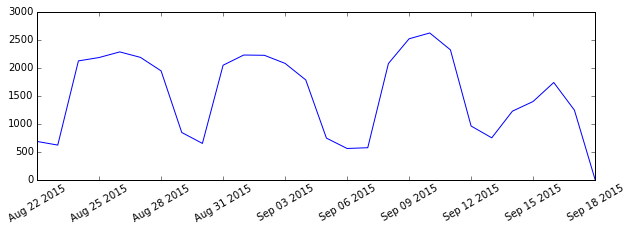

In [17]:
#take dictionary, grab first value(list), sort, 
#separate dates and counts into individual lists and plot dates as x and counts and y
%matplotlib inline
import matplotlib.pyplot as plt

def plot_counts(count_dict):
    dates = []
    counts = []
    sample_key = count_dict.items()[0][0]
    sample_list = sorted(count_dict[sample_key])
    for d, c in sample_list:
        dates.append(d)
        counts.append(c)
    plt.figure(figsize=(10,3))
    plt.plot(dates, counts)
    plt.xticks(rotation=30)
    plt.show()
    
plot_counts(day_counts)    

###Challenge 5

In [18]:
#iterate through items, create new station key, concat all turnstile values within respective station keys
combined_station_day_counts = {}
station_day_counts = {}
for turnst, counts in day_counts.items():
    station = (turnst[0], turnst[1], turnst[3])
    combined_station_day_counts[station] = combined_station_day_counts.get(station, []) + counts

combined_station_day_counts.items()[0]

(('N325A', 'R218', 'ELMHURST AVE'),
 [(datetime.date(2015, 8, 22), 1465),
  (datetime.date(2015, 8, 23), 1158),
  (datetime.date(2015, 8, 24), 2441),
  (datetime.date(2015, 8, 25), 2512),
  (datetime.date(2015, 8, 26), 2638),
  (datetime.date(2015, 8, 27), 2571),
  (datetime.date(2015, 8, 28), 2630),
  (datetime.date(2015, 8, 29), 1502),
  (datetime.date(2015, 8, 30), 1210),
  (datetime.date(2015, 8, 31), 2312),
  (datetime.date(2015, 9, 1), 2544),
  (datetime.date(2015, 9, 2), 2646),
  (datetime.date(2015, 9, 3), 2691),
  (datetime.date(2015, 9, 4), 2605),
  (datetime.date(2015, 9, 5), 1542),
  (datetime.date(2015, 9, 6), 1295),
  (datetime.date(2015, 9, 7), 1254),
  (datetime.date(2015, 9, 8), 2637),
  (datetime.date(2015, 9, 9), 2922),
  (datetime.date(2015, 9, 10), 2979),
  (datetime.date(2015, 9, 11), 3203),
  (datetime.date(2015, 9, 12), 1583),
  (datetime.date(2015, 9, 13), 1353),
  (datetime.date(2015, 9, 14), 2567),
  (datetime.date(2015, 9, 15), 2622),
  (datetime.date(2015, 

###Challenge 6

In [19]:
#iterate, within each station create date dictionary to add up values with same dates, 
#turn date dictionary back into list of tuples
for station, counts in combined_station_day_counts.items():
    dates = {}
    for d, c in counts:
        dates[d] = dates.get(d, 0) + c
    station_day_counts[station] = dates.items()

station_day_counts.items()[0]

(('N325A', 'R218', 'ELMHURST AVE'),
 [(datetime.date(2015, 9, 8), 13476),
  (datetime.date(2015, 9, 10), 14126),
  (datetime.date(2015, 9, 12), 9596),
  (datetime.date(2015, 8, 31), 12592),
  (datetime.date(2015, 9, 14), 12860),
  (datetime.date(2015, 8, 29), 8888),
  (datetime.date(2015, 8, 27), 12812),
  (datetime.date(2015, 9, 2), 12991),
  (datetime.date(2015, 8, 25), 12616),
  (datetime.date(2015, 9, 4), 12977),
  (datetime.date(2015, 9, 17), 14159),
  (datetime.date(2015, 8, 23), 7502),
  (datetime.date(2015, 9, 6), 7888),
  (datetime.date(2015, 9, 9), 13968),
  (datetime.date(2015, 9, 11), 14425),
  (datetime.date(2015, 9, 13), 8129),
  (datetime.date(2015, 8, 30), 7466),
  (datetime.date(2015, 9, 15), 13004),
  (datetime.date(2015, 8, 28), 12870),
  (datetime.date(2015, 9, 1), 12927),
  (datetime.date(2015, 8, 26), 12754),
  (datetime.date(2015, 9, 3), 12978),
  (datetime.date(2015, 8, 24), 12329),
  (datetime.date(2015, 9, 5), 8984),
  (datetime.date(2015, 8, 22), 8660),
  (da

###Challenge 7

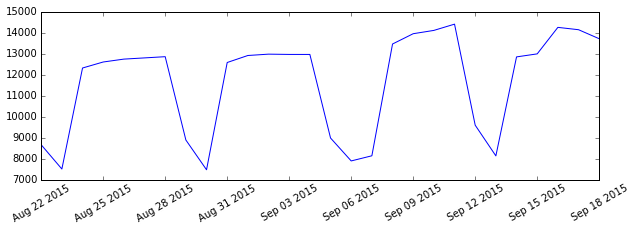

In [20]:
#plot using the routine defined in challenge 4
%matplotlib inline
import matplotlib.pyplot as plt
plot_counts(station_day_counts)

###Challenge 8

In [21]:
week_counts = []
weekdays_count = []
sorted_dates = sorted(station_day_counts.items()[0][1])
counter = 1  

#iterate thru all sorted dates of the first station and store each list of 7 consecutive items (week)
for date, count in sorted_dates:
    weekdays_count.append((date.strftime("%A"), count))
    if counter % 7 == 0:
        week_counts.append(weekdays_count)
        weekdays_count = []
    counter += 1

sorted_week_counts = []

#find monday's index, take slice to the end and move to the beginning
for week in week_counts:
    monday_index = [ix for ix, d in enumerate(week) if d[0] == 'Monday'][0]
    sorted_week_counts.append(week[monday_index:] + week[:monday_index])
sorted_week_counts

[[('Monday', 12329),
  ('Tuesday', 12616),
  ('Wednesday', 12754),
  ('Thursday', 12812),
  ('Friday', 12870),
  ('Saturday', 8660),
  ('Sunday', 7502)],
 [('Monday', 12592),
  ('Tuesday', 12927),
  ('Wednesday', 12991),
  ('Thursday', 12978),
  ('Friday', 12977),
  ('Saturday', 8888),
  ('Sunday', 7466)],
 [('Monday', 8134),
  ('Tuesday', 13476),
  ('Wednesday', 13968),
  ('Thursday', 14126),
  ('Friday', 14425),
  ('Saturday', 8984),
  ('Sunday', 7888)],
 [('Monday', 12860),
  ('Tuesday', 13004),
  ('Wednesday', 14271),
  ('Thursday', 14159),
  ('Friday', 13728),
  ('Saturday', 9596),
  ('Sunday', 8129)]]

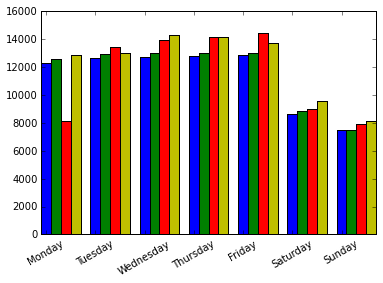

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
    
#get days for labels
week_days = [day for day, count in sorted_week_counts[0]]
counts_by_week = []

#get counts without days for plotting and store each week in its own list
for week in sorted_week_counts:
    counts_by_week.append([count for day, count in week])

w = 0.2
x = np.arange(7)
plt.xticks(x, week_days, rotation=30)
ax = plt.subplot(111)

colors = {0:'b', 1:'g', 2:'r', 3:'y'}

#iterate colors/weeks and define each bar
for offset, color in colors.items():
    ax.bar(x+offset*w, counts_by_week[offset],width=w,color=color, align='center')

###Challenge 9

In [24]:
#iterate, sum counts with each station, also store separate list of summed counts
#get top stations by selecting ones whose percentile rank of counts is above 98% 
import operator
import scipy.stats as stats
station_total_counts = {}
station_sums = []

for station, dates in station_day_counts.items():
    station_sum = sum(c for d, c in dates)
    station_total_counts[station] = station_sum
    station_sums.append(station_sum)

top_stations = [(s, c) for s, c in station_total_counts.items() if stats.percentileofscore(station_sums, c) > 98]

sorted(top_stations, key=lambda t: t[1], reverse=True)

[(('R238', 'R046', '42 ST-GRD CNTRL'), 1583811),
 (('R250', 'R179', '86 ST'), 1173497),
 (('R138', 'R293', '34 ST-PENN STA'), 1080551),
 (('R533', 'R055', 'MAIN ST'), 1072361),
 (('PTH08', 'R540', 'PATH WTC'), 1065795),
 (('N324', 'R018', 'ROOSEVELT AVE'), 923295),
 (('R240', 'R047', '42 ST-GRD CNTRL'), 855886),
 (('R221', 'R170', '14 ST-UNION SQ'), 829064),
 (('N506', 'R022', '34 ST-HERALD SQ'), 815186),
 (('N051', 'R084', '59 ST-COLUMBUS'), 798554),
 (('R246', 'R177', '68ST-HUNTER COL'), 772613),
 (('N606', 'R025', 'JAMAICA CENTER'), 727666),
 (('N083', 'R138', 'W 4 ST-WASH SQ'), 700474),
 (('H009', 'R235', 'BEDFORD AVE'), 699966),
 (('R151', 'R033', '42 ST-TIMES SQ'), 676855)]

###Challenge 10

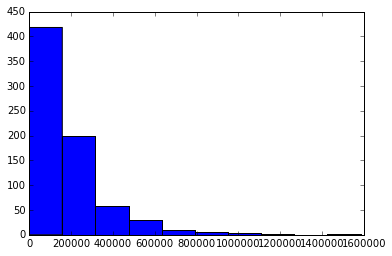

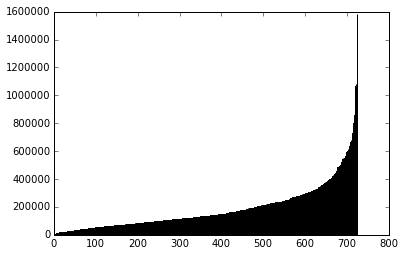

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

total_counts = []

for station, count in station_total_counts.items():
    total_counts.append(count)

total_counts.sort()
plt.hist(total_counts)
plt.show()

indices = range(len(total_counts))
plt.bar(indices, total_counts)
plt.show()